In [1]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import colour
from random import randint as rint
import numpy as np
from colour import Color
from data.sample_planar_partial import *

In [2]:
start, end = 3, 37
unvalid_pos = []
for x in range(start, end + 1):
    for y in range(start, end + 1):
        s = [x,y]
        if is_colliding(np.array(s)):
            unvalid_pos.append(s)
unvalid_pos

[[10, 20],
 [10, 21],
 [11, 20],
 [11, 21],
 [20, 5],
 [20, 6],
 [20, 12],
 [20, 13],
 [20, 27],
 [20, 28],
 [20, 35],
 [20, 36],
 [21, 5],
 [21, 6],
 [21, 12],
 [21, 13],
 [21, 27],
 [21, 28],
 [21, 35],
 [21, 36],
 [30, 20],
 [30, 21],
 [31, 20],
 [31, 21]]

In [3]:
red = Color('blue')
# red_rgb = np.array(Color('red').rgb)
# blue_rgb = np.array(Color('blue').rgb)
colors = list(red.range_to(Color("red"),36))
colors_rgb = [color.rgb for color in colors]
# print (colors_rgb)

In [4]:
def random_gradient():
    img = Image.new("RGB", (width,height), "#FFFFFF")
    draw = ImageDraw.Draw(img)
    
    for i, color in zip(range(start, end+1), colors_rgb):
        r1, g1, b1 = color[0] * 255., color[1] * 255., color[2] * 255.
        draw.line((i,start,i,end), fill=(int(r1), int(g1), int(b1)))
        
    # obstacles as white
#     for y, x in obstacles_center:
#         draw.rectangle(((x - r, y - r), (x + r, y + r)), fill="white")

    img_arr = np.array(img)
    for x, y in unvalid_pos:
        img_arr[x, y] = 255.
    return img_arr / 255., img

In [5]:
img_arr, img = random_gradient()

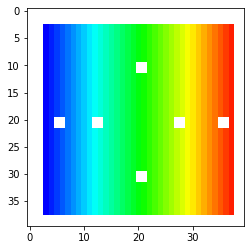

In [6]:
plt.imshow(img_arr)
# plt.axis('off')
plt.show()

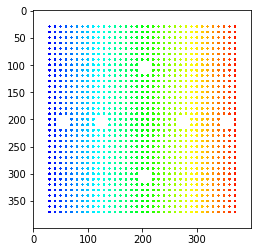

In [7]:
img_scaled = Image.new("RGB", (width * 10,height*10), "#FFFFFF")
draw = ImageDraw.Draw(img_scaled)
for y in range(start, end + 1):
    for x in range(start, end + 1):
        if [y, x] in unvalid_pos:
            continue
        else:
            x_scaled, y_scaled = x * 10, y * 10
            draw.ellipse((x_scaled-2, y_scaled-2, x_scaled+2, y_scaled+2), fill = img.getpixel((x,y)))
img_scaled.save('map.png', 'PNG')
img_arr_scaled = np.array(img_scaled) / 255.
plt.imshow(img_arr_scaled)
plt.show()

In [31]:
import torch
from e2c_model import E2C

In [32]:
model = E2C(1600,2,2,'planar_partial').cuda(0)
model.load_state_dict(torch.load('result/planar_partial/log_check_valid/model_5000'))
model.eval()

E2C(
  (encoder): PlanarEncoder(
    (net): Sequential(
      (0): Linear(in_features=1600, out_features=150, bias=True)
      (1): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=150, out_features=150, bias=True)
      (4): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Linear(in_features=150, out_features=150, bias=True)
      (7): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
      (9): Linear(in_features=150, out_features=4, bias=True)
    )
  )
  (decoder): PlanarDecoder(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=200, bias=True)
      (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Linear(in_features=200, out_features=200, bias=True)
      (4): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=Tr

In [33]:
all_z = []
for x in range(start, end + 1):
    for y in range(start, end + 1):
        s = np.array([x,y])
        if [x,y] in unvalid_pos:
            all_z.append(np.zeros(2))
        else:
            obs = render(s)
            with torch.no_grad():
                obs = torch.Tensor(render(s)).unsqueeze(0).view(-1,1600).double().cuda(0)
                mu, sigma = model.encode(obs)
            z = mu.squeeze().cpu().numpy()
            all_z.append(np.copy(z))
all_z = np.array(all_z)

In [34]:
z_min = np.min(all_z, axis = 0)
z_max = np.max(all_z, axis = 0)
all_z = np.round(5 * all_z + 20).astype(np.int)
# all_z = (all_z - z_min)
latent_map = {}
i = 0
for x in range(start, end + 1):
    for y in range(start, end + 1):
        latent_map[(x,y)] = all_z[i]
        i += 1
for k in latent_map:
    print (str(k) + ': ' + str(latent_map[k]))

(3, 3): [23  3]
(3, 4): [23  3]
(3, 5): [22  3]
(3, 6): [22  1]
(3, 7): [21  2]
(3, 8): [21  1]
(3, 9): [20  3]
(3, 10): [20  8]
(3, 11): [20 10]
(3, 12): [20 12]
(3, 13): [20 13]
(3, 14): [20 13]
(3, 15): [20 14]
(3, 16): [20 14]
(3, 17): [20 15]
(3, 18): [19 15]
(3, 19): [19 15]
(3, 20): [19 16]
(3, 21): [19 24]
(3, 22): [19 24]
(3, 23): [20 24]
(3, 24): [20 24]
(3, 25): [20 24]
(3, 26): [20 24]
(3, 27): [21 24]
(3, 28): [21 23]
(3, 29): [21 23]
(3, 30): [22 23]
(3, 31): [22 23]
(3, 32): [22 15]
(3, 33): [22 14]
(3, 34): [23 13]
(3, 35): [23 12]
(3, 36): [23 11]
(3, 37): [23 10]
(4, 3): [23  6]
(4, 4): [22  5]
(4, 5): [22  5]
(4, 6): [22  3]
(4, 7): [21  4]
(4, 8): [21  2]
(4, 9): [20  2]
(4, 10): [20  5]
(4, 11): [20  8]
(4, 12): [20 11]
(4, 13): [20 12]
(4, 14): [19 13]
(4, 15): [19 13]
(4, 16): [19 14]
(4, 17): [19 14]
(4, 18): [19 15]
(4, 19): [19 15]
(4, 20): [19 16]
(4, 21): [19 25]
(4, 22): [19 25]
(4, 23): [20 25]
(4, 24): [20 24]
(4, 25): [20 24]
(4, 26): [21 24]
(4, 27): [2

In [35]:
count = 0
sum_diff_x = 0.0
sum_diff_y = 0.0
for i in range(0, all_z.shape[0] - 1):
    sum_diff_x += np.abs(all_z[i][0] - all_z[i+1][0])
    sum_diff_y += np.abs(all_z[i][1] - all_z[i+1][1])
    count += 1
avg_diff_x = sum_diff_x / count
avg_diff_y = sum_diff_y / count
1 / avg_diff_x, 1 / avg_diff_y

(1.0746268656716418, 1.0831858407079646)

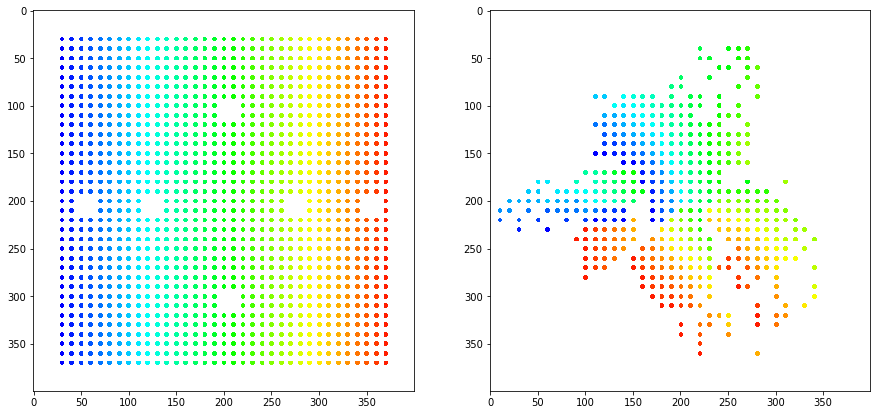

In [43]:
scale = 5
img_latent = Image.new("RGB", (width * 10, height * 10), "#FFFFFF")
draw = ImageDraw.Draw(img_latent)
for k in latent_map:
    x, y = k
    if [x, y] in unvalid_pos:
        continue
    else:
        x_scaled, y_scaled = latent_map[k][1] * 10, latent_map[k][0] * 10
        draw.ellipse((x_scaled-2, y_scaled-2, x_scaled+2, y_scaled+2), fill = img.getpixel((y, x)))
img_latent.save('latent_map.png', 'PNG')
img_latent_scaled = np.array(img_latent) / 255.
# plt.imshow(img_arr_scaled)
# plt.show()
# plt.imshow(img_latent_scaled)
plt.show()
f, axarr = plt.subplots(1,2, figsize=(15,15))
# plt.setp(axarr, xticks=[], yticks=[])
axarr[0].imshow(img_arr_scaled)
axarr[1].imshow(img_latent_scaled)